<a href="https://colab.research.google.com/github/ucfilho/ANN/blob/master/ANN_2022/Image_07/class_007_image_processing_smart_trash_bin_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import pandas as pd
import random
import zipfile
from matplotlib import pyplot as plt
import skimage.feature
from string import digits
import seaborn as sns
import skimage
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
!gdown 1L4mdCDBgybKqr5Wo-kqT8HXcBJ9HXqSX

Downloading...
From: https://drive.google.com/uc?id=1L4mdCDBgybKqr5Wo-kqT8HXcBJ9HXqSX
To: /content/trash_nov_22_2018.zip
100% 42.8M/42.8M [00:00<00:00, 200MB/s]


In [4]:
FILE='trash_nov_22_2018.zip'

In [5]:
archive = zipfile.ZipFile('trash_nov_22_2018.zip', 'r')
archive.extractall()

In [6]:
img_name=[]
with zipfile.ZipFile(FILE, "r") as f:
    for name in f.namelist():
        img_name.append(name)

In [7]:
Img_Size = 224
ref = 'jpg'
notref = 'met'

In [8]:
X= []  
Y =[]
n = len(img_name)
i = 0
for i in range(n):
  name = img_name[i]
  if(ref in name):
    Y.append(name)
    img = cv2.imread(name)
    resized = cv2.resize(img, (Img_Size,Img_Size))
    X.append(resized)
m = len(Y)
print(n,m)

2527 2527


In [9]:
n =len(img_name)
tipos = []
selected = 'find'
for x in img_name:
  result =''.join([i for i in x[:-4] if not i.isdigit()])
  if(result != selected):
    selected = result
    tipos.append(selected)


In [10]:
label =[]
for name in img_name:
  for idx, x in enumerate(tipos):
    if(x in name):
      label.append(idx)

In [11]:
df=pd.DataFrame(label,columns=['target'])

In [12]:
y = pd.get_dummies(df['target'])

In [13]:
for i in range(6): 
  n= df[(df["target"] == i)].shape[0]
  print(tipos[i],n)

cardboard 403
glass 501
metal 410
paper 594
plastic 482
trash 137


In [14]:
#label

In [15]:
n =len(img_name)
data = np.empty((n, 224, 224, 3))

In [16]:
# https://pythontutorials.eu/deep-learning/transfer-learning/

In [17]:
DATASET_SIZE = len(img_name)
Ind = range(DATASET_SIZE)
Ind_train, Ind_test= train_test_split(Ind,test_size=0.20,stratify=label, shuffle=True, random_state=3)
X = np.array(X)
X_train=X[Ind_train]
X_test = X[Ind_test]
y_train=y.iloc[Ind_train,:]
y_test = y.iloc[Ind_test,:]

In [18]:
from keras.applications.mobilenet_v2 import preprocess_input
from skimage.transform import resize
i = 0
for im in X:
    im = preprocess_input(im)
    im = resize(im, output_shape=(224, 224))
    data[i] = im
    i += 1

In [19]:
n

2527

In [20]:
n =len(img_name)
m = len(tipos)

'''
labels_tf = np.empty(n, dtype=int)
for idx, yi in enumerate(label):
  labels_tf[idx] = yi
'''
idx = 0
labels_tf = np.empty([n,m], dtype=int)
for yi in y.values:
  labels_tf[idx] = yi
  idx = idx + 1



In [21]:
import tensorflow as tf
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
# check https://keras.io/api/applications/
#model = MobileNetV2(weights='imagenet')
model = ResNet50(weights='imagenet')

In [22]:
from keras.applications.mobilenet_v2 import decode_predictions

predictions = model.predict(data)
k = 0
for decoded_prediction in decode_predictions(predictions, top=1):
  
  for name, desc, score in decoded_prediction:
      if(k % 200 ==0):
        print('- {} ({:.2f}%%) {}'.format(desc, 100 * score,img_name[k]))
  k = k +1

79/79 [==============================] - 11s 99ms/step
- nematode (13.97%%) cardboard1.jpg
- nematode (11.66%%) cardboard201.jpg
- nematode (15.76%%) cardboard401.jpg
- nematode (16.52%%) glass198.jpg
- nematode (15.65%%) glass398.jpg
- nematode (9.65%%) metal97.jpg
- nematode (12.90%%) metal297.jpg
- nematode (14.93%%) paper87.jpg
- nematode (13.22%%) paper287.jpg
- matchstick (7.24%%) paper487.jpg
- nematode (11.52%%) plastic93.jpg
- nematode (10.52%%) plastic293.jpg
- nematode (12.50%%) trash11.jpg


In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 170

# Freeze all the layers before the `fine_tune_at` layer
# check https://www.tensorflow.org/tutorials/images/transfer_learning
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  177


In [24]:
#from keras.layers import Dense
#D = len(tipos)
#model_output = Dense(D, activation='softmax')

In [25]:
#model_output = model_output(model.layers[-2].output)

In [26]:
D =len(tipos)
model_output = Dense(D, activation= 'softmax') #'relu')
model_output = model_output(model.layers[-2].output)
model_input = model.input
model_new = Model(inputs=model_input, outputs=model_output)

In [27]:
#from keras import Model
#from sklearn.metrics import classification_report, confusion_matrix
#model_input = model.input
#model_model = Model(inputs=model_input, outputs=model_output)

In [28]:
model_new.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
r = model_new.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    verbose=2
)

Epoch 1/40
64/64 - 14s - loss: 0.7664 - accuracy: 0.7516 - val_loss: 0.5668 - val_accuracy: 0.8379 - 14s/epoch - 212ms/step
Epoch 2/40
64/64 - 9s - loss: 0.2120 - accuracy: 0.9273 - val_loss: 0.4785 - val_accuracy: 0.8439 - 9s/epoch - 138ms/step
Epoch 3/40
64/64 - 8s - loss: 0.0779 - accuracy: 0.9857 - val_loss: 0.4204 - val_accuracy: 0.8735 - 8s/epoch - 125ms/step
Epoch 4/40
64/64 - 8s - loss: 0.0400 - accuracy: 0.9965 - val_loss: 0.3800 - val_accuracy: 0.8775 - 8s/epoch - 127ms/step
Epoch 5/40
64/64 - 8s - loss: 0.0354 - accuracy: 0.9941 - val_loss: 0.4207 - val_accuracy: 0.8755 - 8s/epoch - 126ms/step
Epoch 6/40
64/64 - 8s - loss: 0.0403 - accuracy: 0.9941 - val_loss: 0.4907 - val_accuracy: 0.8696 - 8s/epoch - 124ms/step
Epoch 7/40
64/64 - 8s - loss: 0.0267 - accuracy: 0.9970 - val_loss: 0.4608 - val_accuracy: 0.8755 - 8s/epoch - 122ms/step
Epoch 8/40
64/64 - 8s - loss: 0.0320 - accuracy: 0.9946 - val_loss: 0.4384 - val_accuracy: 0.8676 - 8s/epoch - 120ms/step
Epoch 9/40
64/64 - 8s 

In [30]:
def retorna(y):
  resp = []
  for yi in y:
    vmax =max(yi)
    for idx, x in enumerate(yi):
      if(x == vmax):
        resp.append(idx)
  return resp

In [31]:
test_loss, test_acc = model_new.evaluate(X_test,  y_test, verbose=2)

16/16 - 2s - loss: 0.4477 - accuracy: 0.9051 - 2s/epoch - 99ms/step


In [32]:
predict=model_new.predict(X_test)

16/16 [==============================] - 2s 97ms/step


In [33]:
predict[0].shape

(6,)

In [34]:
y_calc = retorna(predict)
y_test = retorna(np.array(y_test))

In [35]:
confusion_matrix(y_test, y_calc)

array([[ 73,   1,   1,   5,   1,   0],
       [  0,  91,   4,   1,   4,   0],
       [  0,   1,  78,   1,   1,   1],
       [  2,   1,   1, 112,   1,   2],
       [  0,  10,   1,   1,  84,   1],
       [  1,   0,   5,   1,   0,  20]])

In [36]:
# Classification Report
print('\n\n', classification_report(y_test, y_calc, target_names=tipos))



               precision    recall  f1-score   support

   cardboard       0.96      0.90      0.93        81
       glass       0.88      0.91      0.89       100
       metal       0.87      0.95      0.91        82
       paper       0.93      0.94      0.93       119
     plastic       0.92      0.87      0.89        97
       trash       0.83      0.74      0.78        27

    accuracy                           0.91       506
   macro avg       0.90      0.89      0.89       506
weighted avg       0.91      0.91      0.90       506



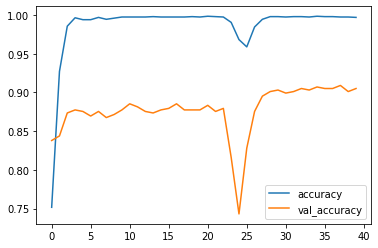

In [37]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

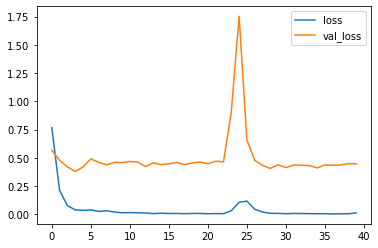

In [38]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()